In [1]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.8 MB/s 
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install sacremoses

     |████████████████████████████████| 880 kB 4.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0eed544f9dc98e664588f40c801e90aa32cb7a3938ece32db5e210cd0c114445
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [3]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 4.8 MB/s 


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
import gc #garbage collector for gpu memory 
from tqdm import tqdm
from argparse import ArgumentParser

from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import nlpaug.augmenter.word as naw

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
train_path = './train.tsv'
test_path = './test.tsv'
val_path = './valid.tsv'
gpt_path = './test.gpt.tsv'

In [6]:
from torch.utils.data import TensorDataset

bert_length = 512

def to_onehot(a):
    a_cat = [0]*len(a)
    for i in range(len(a)):
        if a[i]=='true':
            a_cat[i] = 0
        elif a[i]=='mostly-true':
            a_cat[i] = 0
        elif a[i]=='half-true':
            a_cat[i] = 0
        elif a[i]=='barely-true':
            a_cat[i] = 1
        elif a[i]=='false':
            a_cat[i] = 1
        elif a[i]=='pants-fire':
            a_cat[i] = 1
        else:
            print('Incorrect label')
    return a_cat

def to_onehot_gpt(a):
    a_cat = [0]*len(a)
    for i in range(len(a)):
        if a[i] is True:
            a_cat[i] = 0
        elif a[i] is False:
            a_cat[i] = 1
        else:
            print('Incorrect label')
    return a_cat

def build_dataset(statements,labels,length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    input_ids = []
    attention_masks = []

    for sentance in statements:
        encoded_dict = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = length,
        pad_to_max_length = True,return_attention_mask = True,return_tensors = 'pt')
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids,attention_masks,labels)
    return dataset

# Augmenting Train Data using Back Translation
def augment_text_data(data):
    augmented_data = []
    
    # English-German-English Translation
    back_translation_aug = naw.BackTranslationAug(
        from_model_name='facebook/wmt19-en-de', 
        to_model_name='facebook/wmt19-de-en'
    )

    for article in data:
        augmented_data.append(article)
        if article[1] == "true" or article[1] == "false" or article[1] == "pants-fire":
          augmented_sentence = back_translation_aug.augment(article[2])
          article[2] = augmented_sentence
          augmented_data.append(article)

    return augmented_data


def get_liar_dataset():
    train_df = pd.read_csv(train_path, sep="\t", header=None)
    test_df = pd.read_csv(test_path, sep="\t", header=None)
    val_df = pd.read_csv(val_path, sep="\t", header=None)

    train = train_df.values
    test = test_df.values
    val = val_df.values

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train = augment_text_data(train)

    #print(Counter(train[:,1]))

    labels = {'train':train[:,1], 'test':test[:,1], 'val':val[:,1]}
    statements = {'train':train[:,2], 'test':test[:,2], 'val':val[:,2]}
    subjects = {'train':train[:,3], 'test':test[:,3], 'val':val[:,3]}
    speaker = {'train':train[:,4], 'test':test[:,4], 'val':val[:,4]}
    job = {'train':train[:,5], 'test':test[:,5], 'val':val[:,5]}
    state = {'train':train[:,6], 'test':test[:,6], 'val':val[:,6]}
    affiliation = {'train':train[:,7], 'test':test[:,7], 'val':val[:,7]}

    labels_onehot = {'train':to_onehot(labels['train']), 'test':to_onehot(labels['test']), 'val':to_onehot(labels['val'])}

    train_dataset = build_dataset(statements['train'],labels_onehot['train'],bert_length)
    val_dataset = build_dataset(statements['val'],labels_onehot['val'],bert_length)
    test_dataset = build_dataset(statements['test'],labels_onehot['test'],bert_length)

    return train_dataset, val_dataset, test_dataset

def get_gpt_test_dataset():
    gpt_df = pd.read_csv(gpt_path
    , sep="\t", header=None)
    gpt = gpt_df.values
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    labels = {'test':gpt[:,1]}
    statements = {'test':gpt[:,2]}

    labels_onehot = {'test':to_onehot_gpt(labels['test'])}
    test_dataset = build_dataset(statements['test'],labels_onehot['test'],bert_length)
    return test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = get_liar_dataset()

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

### Batch Size and Number of Epochs

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 16
NUM_EPOCHS = 10

### Loading Train, Val and Test Data

In [7]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)

### Loading Pre-Trained BERT Model

In [8]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 6, # The number of output labels -- 2 for binary classification, here 6
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-6)
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps)
loss_function = nn.BCEWithLogitsLoss()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [9]:
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
train_losses = []
def train(epoch):
    torch.cuda.empty_cache() #memory
    gc.collect() #memory
    model.train()
    total_train_loss = 0
    print("Start training for epoch:",epoch)
    for step,target in enumerate(train_dataloader):
        target_input_id = target[0].to(device)
        target_input_mask = target[1].to(device)
        target_labels = target[2].to(device)

        loss, logits = model(input_ids=target_input_id, attention_mask=target_input_mask, labels=target_labels, return_dict=False)
        total_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            avg_loss = float(total_train_loss / (step+1))
            print('Epoch: {} | Avg Classification Loss: {} | Memory Allocated: {}'.format(epoch, avg_loss, 0))
    print('Trained Epoch {} | Total Avg Loss: {}'.format(epoch, avg_loss))

    train_losses.append(total_train_loss / len(train_dataloader))

In [12]:
val_losses = []
def validation(epoch):
    torch.cuda.empty_cache() #memory
    gc.collect() #memory
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0
    print("Start validation for epoch:",epoch)
    with torch.no_grad():
        for step,target in enumerate(val_dataloader):
            target_input_id = target[0].to(device)
            target_input_mask = target[1].to(device)
            target_labels = target[2].to(device)
            
            loss, logits = model(input_ids=target_input_id, attention_mask=target_input_mask, labels=target_labels, return_dict=False)
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = target_labels.cpu().numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

            if step % 10 == 0:
                avg_loss = float(total_eval_loss / (step+1))
                print('Epoch: {} | Avg Classification Loss: {} | Memory Allocated: {}'.format(epoch, avg_loss, 0))
        print('Trained Epoch {} | Total Avg Loss: {} | Total avg accuracy {}'.format(epoch, avg_loss,total_eval_accuracy/len(val_dataloader)))

    torch.save(model.state_dict(), 'fake_news_classification_{}.pth'.format(epoch))

    val_losses.append(total_eval_loss / len(val_dataloader))

### Training BERT Model on FakeNews Dataset

In [13]:
for ep in range(NUM_EPOCHS):
    train(ep)
    validation(ep)

Start training for epoch: 0
Epoch: 0 | Avg Classification Loss: 2.4853200912475586 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 2.1942815455523403 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 2.06363198303041 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.9094797218999555 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.7944366059652188 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.711937850596858 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.642897428059187 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.597160257084269 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.5540996583891504 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.5204604667621655 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.4940531961988694 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.469485633008115 | Memory Allocated: 0
Epoch: 0 | Avg Classification Loss: 1.4433194625476176

In [14]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Parameters: " + str(count_parameters(model)))

Number of Parameters: 108314886


Text(0, 0.5, 'Validation Loss')

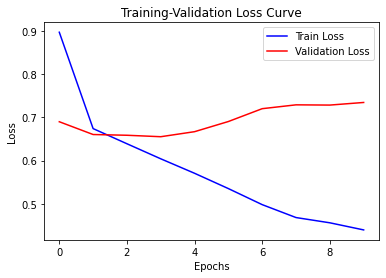

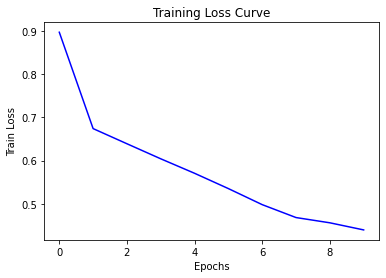

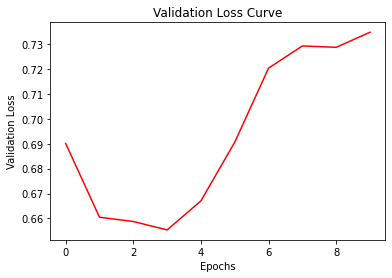

In [15]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(train_losses, 'b')
plt.plot(val_losses, 'r')
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Training-Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.figure(2)
plt.plot(train_losses, 'b')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.figure(3)
plt.plot(val_losses, 'r')
plt.title("Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")